In [1]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups 
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
import pandas as pd
import numpy as np
import nltk
import re
#!pip install ntlk

In [2]:
with open('movie_summaries_bottom_250.txt', 'r') as myfile:
    summary=myfile.readlines()
with open('movie_titles_bottom_250.txt', 'r') as my_file:
    titles=my_file.readlines()

    from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
stopwords = nltk.corpus.stopwords.words('english')

In [7]:
!pip install mpld3
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3


  Running setup.py bdist_wheel for mpld3: started
  Running setup.py bdist_wheel for mpld3: finished with status 'done'
  Stored in directory: C:\Users\Rajeev Ranjan\AppData\Local\pip\Cache\wheels\c0\47\fb\8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


twisted 17.9.0 has requirement Automat>=0.3.0, but you'll have automat 0.0.0 which is incompatible.


In [8]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
additional=[':anonymous', "'s","'a",':anonym']
stopwords.extend(additional)

In [9]:
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [10]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [11]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [12]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in summary:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [13]:
len(totalvocab_stemmed)
len(totalvocab_tokenized)

29097

In [14]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
'there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame'

'there are 29097 items in vocab_frame'

In [15]:
vocab_frame.head()

,words
the,'the
emoji,emoji
movi,movie
unlock,unlocks
the,the


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(summary) #fit the vectorizer to summary

print(tfidf_matrix.shape)

Wall time: 1.05 s
(249, 35)


In [17]:
terms = tfidf_vectorizer.get_feature_names()
terms

['becom',
 'befor',
 'come',
 'decid',
 'evil',
 'father',
 'forc',
 'friend',
 'girl',
 'group',
 'help',
 'howev',
 'kill',
 'life',
 'live',
 'love',
 'make',
 'man',
 'new',
 'onli',
 'order',
 'peopl',
 'plan',
 'power',
 'save',
 'stori',
 'time',
 'tri',
 'turn',
 'use',
 'want',
 'way',
 'world',
 'year',
 'young']

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [19]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 130 ms


In [20]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [21]:
df=pd.read_csv('Combine_bottom.csv')
title=df['Title']
rank=df.index

In [22]:
films = {  'cluster': clusters}

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])
frame['rank']=rank

In [23]:
frame['title']=pd.Series(titles).values

In [24]:
frame.head()

,rank,title,cluster
0,0,The Emoji Movie\n,0
2,1,Nothing to Lose\n,2
3,2,Battlefield Earth\n,3
3,3,Dragonball: Evolution\n,3
2,4,Jaws: The Revenge\n,2


In [25]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

0    78
2    73
1    41
3    31
4    26
Name: cluster, dtype: int64

In [26]:
grouped = frame['rank'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average rank (1 to 100) per cluster

cluster
0    125.910256
1    119.073171
2    139.753425
3    105.935484
4    103.346154
Name: rank, dtype: float64

In [27]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'life', b'world', b'story', b'turn', b'become', b'girls',

Cluster 0 titles: The Emoji Movie
, The Human Centipede III (Final Sequence)
, Spice World
, Catwoman
, Jack and Jill
, Bratz
, Meet the Spartans
, Captain America
, Barb Wire
, The Starving Games
, #Horror
, Going Overboard
, Foodfight!
, Baby Geniuses
, Bolero
, The Garbage Pail Kids Movie
, Daddy Day Camp
, The Crow: Wicked Prayer
, Teen Wolf Too
, Police Academy: Mission to Moscow
, Bucky Larson: Born to Be a Star
, Titanic: The Legend Goes On...
, Feardotcom
, InAPPropriate Comedy
, Sand Sharks
, Tekken: Kazuya's Revenge
, Dracula 3000
, Larry the Cable Guy: Health Inspector
, Zombie Nation
, Girl in Gold Boots
, Avalanche Sharks
, Chairman of the Board
, Smolensk
, Hole in One
, Gunday
, Apartment 1303 3D
, Surf School
, Seed
, Mega Shark vs. Mecha Shark
, Super Shark
, Phat Girlz
, Simon Sez
, Ghosts Can't Do It
, Witless Protection
, Tees Maar Khan
, Fat Slags
, Ben & Arthur
, P

c:\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
c:\anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [28]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [29]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'girls, making, wants', 
                 1: 'world, become, powerful', 
                 2: 'life, trying, turn', 
                 3: 'evil, world, save', 
                 4: 'group,story,people'}

#b'girls', b'making', b'wants', b'friend', b'father', b'year'
#b'world', b'become', b'powerful', b'time', b'killed', b'using',
#b'life', b'trying', b'turn', b'new', b'only', b'love',
#b'evil', b'world', b'save', b'help', b'forces', b'before',
#b'group', b'story', b'people', b'friend', b'young', b'comes',

c:\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
c:\anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


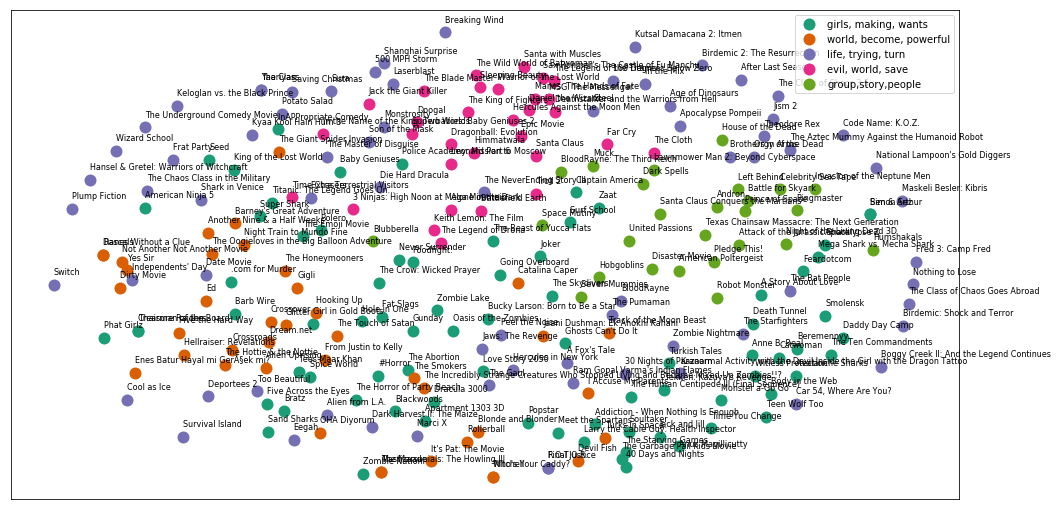

In [30]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [31]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [32]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

c:\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


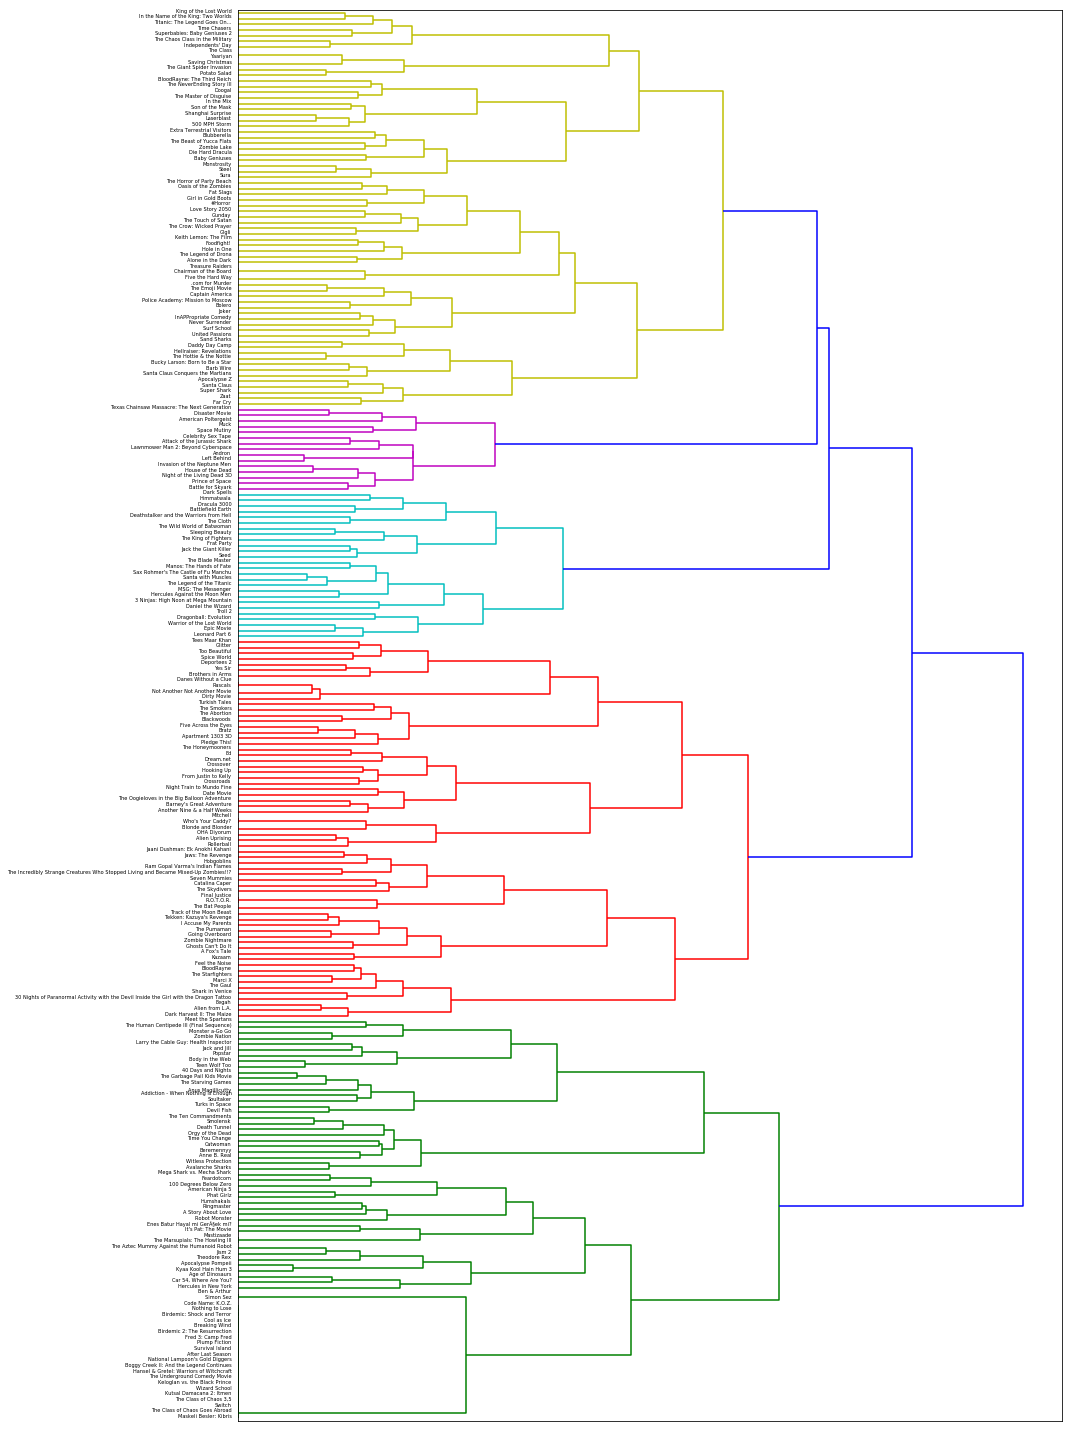

In [33]:

from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters